In [1]:
%load_ext autoreload

# trick for importing from different directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
import xgboost as xgb

/home/joe/kaggle/wiki_forecasting/.env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

In [4]:
cv=GroupKFold(2)

%autoreload 2
from wiki_forecasting.data_utils import prepare_data

cv_scores = []
test_scores = []
imps = []
for prediction_gap in range(1, 61, 10):
    X, y, sums, X_test, y_test, sums_test, df = prepare_data(prediction_gap)
    X["date_code"] = X["date_code"] // 20
    model = xgb.XGBRegressor(n_estimators=32)
    preds = cross_val_predict(model,
                              X.drop(["date", "date_code"], axis=1), np.log(y+1),
                              groups=X["date_code"], cv=cv)
    cv_score = smape(y, np.exp(preds)-1)
    cv_scores.append(cv_score)
    
    model = model.fit(
        X.drop(["date", "date_code"], axis=1),
        np.log(y+1)
    )
    preds =  model.predict(X_test.drop(["date", "date_code"], axis=1))
    b = model.booster()
    imps.append(b.get_fscore())
    
    test_score = smape(y_test, np.exp(preds) - 1)
    test_scores.append(test_score)
    print(prediction_gap, cv_score, test_score)

1 41.3461 40.7796
11 43.6674 42.7912
21 44.7235 44.4873
31 45.0621 45.4326
41 45.3544 45.6891
51 45.8573 45.4468


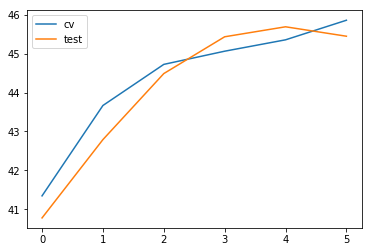

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(cv_scores, label="cv")
plt.plot(test_scores, label="test")
plt.legend()

In [7]:
import pandas as pd
pd.DataFrame(imps)

,day,ewm,med1,med2,med3,med_day,median,page,us_holiday
0,2.0,54,76,31,16,18,8,11,8
1,NaN,48,56,39,21,4,35,17,4
2,NaN,41,39,46,28,18,24,20,8
3,NaN,38,33,46,29,10,38,27,3
4,1.0,45,38,40,28,13,39,16,3
5,NaN,36,32,55,18,15,47,18,3
